In [1]:
import os
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
from scipy import ndimage as ndi
from distributed import LocalCluster
from pyproj import Transformer

In [2]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63001 instead
  warnings.warn(


LocalCluster(de24cf94, 'inproc://10.67.42.116/11436/1', workers=1, threads=16, memory=31.26 GiB)

In [3]:
# Define AOI and convert to raster CRS
spatial_extent = {
    "west": 3.547150,
    "south": 50.865238,
    "east": 3.548602,
    "north": 50.866717,
}

bbox_4326 = [
    spatial_extent["west"],
    spatial_extent["south"],
    spatial_extent["east"],
    spatial_extent["north"],
]

# Convert AOI to UTM 33N (same as Sentinel-2 data)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32631", always_xy=True)
west_utm, south_utm = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east_utm, north_utm = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

# Spatial slice parameters
x_slice = slice(west_utm, east_utm)
y_slice = slice(north_utm, south_utm)

In [4]:
# Connect to the STAC catalog
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")

# Search for Sentinel-2 L2A items within a specific bounding box and date range
search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox_4326,
    datetime="2018-11-01/2020-02-01",
)

# Retrieve the list of matching items
items = list(search.items())
hrefs = [item.assets["product"].href for item in items]

In [5]:
print(f"List of first Five Items returned from the STAC query: {items[:5]}")
print(f"List of first Five Zarr URLs returned from the STAC query: {hrefs[:5]}")

List of first Five Items returned from the STAC query: [<Item id=S02MSIL2A_20200131T105251_0000_A051_T973>, <Item id=S02MSIL2A_20200129T110209_0000_B094_T881>, <Item id=S02MSIL2A_20200126T105229_0000_B051_T215>, <Item id=S02MSIL2A_20200124T110331_0000_A094_T671>, <Item id=S02MSIL2A_20200121T105341_0000_A051_T512>]
List of first Five Zarr URLs returned from the STAC query: ['https://objects.eodc.eu/e05ab01a9d56408d82ac32d69a5aae2a:notebook-data/tutorial_data/cpm_v260/S2A_MSIL2A_20200131T105251_N0500_R051_T31UES_20230426T102522.zarr', 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:notebook-data/tutorial_data/cpm_v260/S2B_MSIL2A_20200129T110209_N0500_R094_T31UES_20230628T193235.zarr', 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:notebook-data/tutorial_data/cpm_v260/S2B_MSIL2A_20200126T105229_N0500_R051_T31UES_20230428T121217.zarr', 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:notebook-data/tutorial_data/cpm_v260/S2A_MSIL2A_20200124T110331_N

In [6]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)


datacube = xr.open_mfdataset(
    hrefs,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r10m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    mask_and_scale=True,
).sortby("time", ascending=True)

datacube = datacube[["b04", "b08"]].sel(x=x_slice, y=y_slice)
datacube

<xarray.Dataset> Size: 537kB
Dimensions:  (time: 179, y: 17, x: 11)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2018-11-02T10:52:09 ... 2020-01-31T10:...
  * y        (y) float32 68B 5.635e+06 5.635e+06 ... 5.635e+06 5.635e+06
  * x        (x) float32 44B 5.385e+05 5.385e+05 ... 5.386e+05 5.386e+05
Data variables:
    b04      (time, y, x) float64 268kB dask.array<chunksize=(1, 17, 11), meta=np.ndarray>
    b08      (time, y, x) float64 268kB dask.array<chunksize=(1, 17, 11), meta=np.ndarray>

In [7]:
scl = xr.open_mfdataset(
    hrefs,
    engine="zarr",
    chunks={},
    group="/conditions/mask/l2a_classification/r20m",  # Adjust if necessary
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    mask_and_scale=True,
).sortby("time", ascending=True)[["scl"]]
scl_resampled = scl.scl.interp_like(datacube, method="nearest")
datacube["scl"] = scl_resampled
datacube = datacube.compute()
datacube

C:\Users\justi\AppData\Roaming\Python\Python314\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 9.88 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


<xarray.Dataset> Size: 805kB
Dimensions:  (time: 179, y: 17, x: 11)
Coordinates:
  * time     (time) datetime64[ns] 1kB 2018-11-02T10:52:09 ... 2020-01-31T10:...
  * y        (y) float32 68B 5.635e+06 5.635e+06 ... 5.635e+06 5.635e+06
  * x        (x) float32 44B 5.385e+05 5.385e+05 ... 5.386e+05 5.386e+05
Data variables:
    b04      (time, y, x) float64 268kB 0.1302 0.1308 0.1278 ... 0.3848 0.398
    b08      (time, y, x) float64 268kB 0.2113 0.2208 0.2223 ... 0.4256 0.4348
    scl      (time, y, x) float64 268kB 5.0 5.0 5.0 5.0 5.0 ... 9.0 9.0 9.0 9.0

In [8]:
def circular_kernel(radius: int) -> np.ndarray:
    """Create a 2D circular (disk) kernel with given radius in pixels."""
    r = int(radius)
    y, x = np.ogrid[-r : r + 1, -r : r + 1]
    k = (x * x + y * y) <= (r * r)
    return k.astype(np.float32)


def _dilate_with_convolve(mask_2d: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Dilate a boolean mask using convolution with a (0/1) kernel.
    Returns a boolean array where any overlap with the kernel sets True.
    """
    if mask_2d.dtype != np.float32:
        mask_2d = mask_2d.astype(np.float32, copy=False)
    # Convolution counts how many True pixels fall under the kernel footprint.
    conv = ndi.convolve(mask_2d, kernel, mode="constant", cval=0.0)
    return conv > 0.0


def _apply_dilation_block(
    scl_block: np.ndarray, k1: np.ndarray, k2: np.ndarray
) -> np.ndarray:
    """
    Core block function (works on 2D arrays). Returns combined dilated mask (bool).
    Implements the openEO SCL logic used by mask_scl_dilation.
    """
    # S2 Sen2Cor SCL classes (for reference):
    #  0 NODATA, 1 SAT/DEF, 2 DARK, 3 CLOUD_SHADOW, 4 VEG, 5 NOT_VEG,
    #  6 WATER, 7 UNCLASS, 8 CLOUD_MED, 9 CLOUD_HIGH, 10 THIN_CIRRUS, 11 SNOW
    # openEO mask_scl_dilation uses:
    #   mask1 = everything except {2,4,5,6,7}  (aggressive neighbourhood removal)
    #   mask2 = {3,8,9,10,11}                  (clouds, shadows, snow)
    scl = scl_block.astype(np.int16, copy=False)

    mask1 = (scl != 2) & (scl != 4) & (scl != 5) & (scl != 6) & (scl != 7)
    mask2 = (scl == 3) | (scl == 8) | (scl == 9) | (scl == 10) | (scl == 11)

    dil1 = _dilate_with_convolve(mask1, k1)
    dil2 = _dilate_with_convolve(mask2, k2)

    combined = dil1 | dil2
    return combined


def mask_scl_dilation(
    ds: xr.Dataset, *, time_band_name: str = "time", scl_band_name: str = "scl"
) -> xr.Dataset:
    """
    Apply the mask_scl_dilation to an xarray Dataset containing a Sentinel-2 SCL band.

    Parameters
    ----------
    ds : xr.Dataset
        Must contain an integer SCL classification band.
        Expected dims include (y, x) and optionally time-like dims (e.g. t).
    time_band_name: str
        Name of the time dimension in 'ds'
    scl_band_name : str
        Name of the SCL band in `ds`.

    Returns
    -------
    xr.Dataset
        Same as input, with selected bands masked (set to NaN) wherever the dilated mask is True.
    """

    if scl_band_name not in ds:
        raise ValueError(
            f"{scl_band_name!r} not found in dataset variables: {list(ds.data_vars)}"
        )

    # Validate time dimension exists in dataset
    if time_band_name not in ds.dims:
        raise ValueError(
            f"{time_band_name!r} not found in dataset dimensions: {list(ds.dims)}"
        )

    kernel1 = circular_kernel(radius=8)
    kernel2 = circular_kernel(radius=100)

    scl = ds[scl_band_name]

    # Figure out which dims are spatial:
    # Try common names first, fallback to guessing the last two dims are (y, x)
    cand_xy = [d for d in ["y", "x"] if d in scl.dims]
    if len(cand_xy) != 2:
        # Guess last two dims in order
        cand_xy = list(scl.dims[-2:])
    ydim, xdim = cand_xy

    # Build dilated mask with apply_ufunc so it's Dask-friendly and vectorized over non-spatial dims.
    dilated = xr.apply_ufunc(
        _apply_dilation_block,
        scl,
        input_core_dims=[[ydim, xdim]],
        output_core_dims=[[ydim, xdim]],
        kwargs={"k1": kernel1.astype(np.float32), "k2": kernel2.astype(np.float32)},
        dask="parallelized",
        vectorize=True,
        output_dtypes=[bool],
        dask_gufunc_kwargs={"allow_rechunk": True},
    ).rename("dilated_mask")

    bands_to_mask = [v for v in ds.data_vars if v != scl_band_name]

    # Align masking array to each band (xarray broadcasting handles extra dims)
    out = ds.copy()
    for var in bands_to_mask:
        da = out[var]
        # Mask (set to NaN where dilated mask is True)
        # Preserve dtype for integer bands by promoting to float to allow NaNs
        if np.issubdtype(da.dtype, np.integer):
            da = da.astype(np.float32)
        out[var] = da.where(~dilated)

    out = out.drop_vars(scl_band_name)

    # Build a keep mask over time dimension
    keep = xr.concat(
        [out[v].notnull().any((ydim, xdim)) for v in bands_to_mask], dim="vars"
    ).any("vars")

    # Apply time filtering
    out = out.sel({time_band_name: keep})

    return out


# Usage examples
masked_ds = mask_scl_dilation(datacube, time_band_name="time", scl_band_name="scl")
masked_ds

<xarray.Dataset> Size: 162kB
Dimensions:  (time: 54, y: 17, x: 11)
Coordinates:
  * time     (time) datetime64[ns] 432B 2018-11-05T11:02:29 ... 2020-01-29T11...
  * y        (y) float32 68B 5.635e+06 5.635e+06 ... 5.635e+06 5.635e+06
  * x        (x) float32 44B 5.385e+05 5.385e+05 ... 5.386e+05 5.386e+05
Data variables:
    b04      (time, y, x) float64 81kB 0.1146 0.1086 0.1116 ... 0.0558 0.0575
    b08      (time, y, x) float64 81kB 0.1756 0.178 0.178 ... 0.4212 0.4144

In [9]:
def compute_ndvi(ds: xr.Dataset) -> xr.DataArray:
    nir = ds["b08"].astype("float32")
    red = ds["b04"].astype("float32")
    num = nir - red
    den = nir + red
    ndvi = xr.where(den != 0, num / den, np.nan)
    ndvi.name = "NDVI"

    return ndvi


ndvi_dataset = compute_ndvi(masked_ds)
ndvi_dataset

<xarray.DataArray 'NDVI' (time: 54, y: 17, x: 11)> Size: 40kB
array([[[0.21019988, 0.24214935, 0.22928178, ..., 0.80368096,
         0.80248284, 0.81940293],
        [0.22866896, 0.25755587, 0.31112507, ..., 0.8392953 ,
         0.80554533, 0.81163234],
        [0.3460591 , 0.52219176, 0.67144835, ..., 0.8734524 ,
         0.83370125, 0.8211981 ],
        ...,
        [0.9031357 , 0.8977909 , 0.9002971 , ..., 0.69367236,
         0.68090457, 0.65582573],
        [0.8971543 , 0.8914569 , 0.8787879 , ..., 0.67926323,
         0.6668802 , 0.63560146],
        [0.86957353, 0.82238716, 0.7633075 , ..., 0.6831551 ,
         0.66876036, 0.63442296]],

       [[0.19572954, 0.21020818, 0.2700065 , ..., 0.8352758 ,
         0.8147724 , 0.78355885],
        [0.29064655, 0.45594713, 0.6308852 , ..., 0.87334913,
         0.8461538 , 0.80218714],
        [0.6808511 , 0.7991664 , 0.8577687 , ..., 0.88494885,
         0.8776078 , 0.83023876],
...
        [0.3626245 , 0.37411767, 0.37979916, ..., 0.7579144 ,
         0.77939844, 0.7868296 ],
        [0.39706746, 0.4269827 , 0.46848986, ..., 0.7683824 ,
         0.7826585 , 0.7783882 ],
        [0.51228064, 0.60160047, 0.6878739 , ..., 0.7743613 ,
         0.77982074, 0.7595526 ]],

       [[0.56243944, 0.57610244, 0.57650405, ..., 0.46608695,
         0.66251415, 0.7202073 ],
        [0.5421687 , 0.5028463 , 0.46481568, ..., 0.41386643,
         0.53834295, 0.6494134 ],
        [0.42460504, 0.39222276, 0.3872549 , ..., 0.3801269 ,
         0.43435147, 0.5565032 ],
        ...,
        [0.35429144, 0.36444008, 0.41713122, ..., 0.7822909 ,
         0.8047471 , 0.78658414],
        [0.47614214, 0.5660848 , 0.6597189 , ..., 0.7739274 ,
         0.78363895, 0.77852064],
        [0.71523964, 0.75357383, 0.77447546, ..., 0.78220284,
         0.76603776, 0.75630426]]], shape=(54, 17, 11), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 432B 2018-11-05T11:02:29 ... 2020-01-29T11...
  * y        (y) float32 68B 5.635e+06 5.635e+06 ... 5.635e+06 5.635e+06
  * x        (x) float32 44B 5.385e+05 5.385e+05 ... 5.386e+05 5.386e+05

In [10]:
def aggregate_to_dekad(ds: xr.Dataset, time_dim="time") -> xr.Dataset:
    """
    Group by dekad (10-day periods) and compute mean NDVI.
    """
    # Create dekad labels
    time_index = ds[time_dim].to_index()
    dekad_labels = [f"{d.year}-D{(d.dayofyear - 1) // 10 + 1:02}" for d in time_index]
    ds = ds.assign_coords(dekad=("time", dekad_labels))

    # Group by dekad and reduce
    agg_dekad = ds.groupby("dekad").mean(dim="time", keep_attrs=True)

    # Convert dekad labels back to timestamps (approximate mid-dekad date)
    dekad_dates = [
        pd.to_datetime(label.split("-D")[0])
        + pd.to_timedelta((int(label.split("-D")[1]) - 1) * 10 + 5, unit="D")
        for label in agg_dekad.dekad.values
    ]

    # Assign new 'time' coordinate and set it as index
    agg_dekad = (
        agg_dekad.assign_coords(time=("dekad", dekad_dates))
        .swap_dims({"dekad": "time"})
        .drop_vars("dekad")
    )

    return agg_dekad


agg_dekad = aggregate_to_dekad(ndvi_dataset)
agg_dekad

<xarray.DataArray 'NDVI' (time: 34, y: 17, x: 11)> Size: 25kB
array([[[0.21019988, 0.24214935, 0.22928178, ..., 0.80368096,
         0.80248284, 0.81940293],
        [0.22866896, 0.25755587, 0.31112507, ..., 0.8392953 ,
         0.80554533, 0.81163234],
        [0.3460591 , 0.52219176, 0.67144835, ..., 0.8734524 ,
         0.83370125, 0.8211981 ],
        ...,
        [0.9031357 , 0.8977909 , 0.9002971 , ..., 0.69367236,
         0.68090457, 0.65582573],
        [0.8971543 , 0.8914569 , 0.8787879 , ..., 0.67926323,
         0.6668802 , 0.63560146],
        [0.86957353, 0.82238716, 0.7633075 , ..., 0.6831551 ,
         0.66876036, 0.63442296]],

       [[0.19572954, 0.21020818, 0.2700065 , ..., 0.8352758 ,
         0.8147724 , 0.78355885],
        [0.29064655, 0.45594713, 0.6308852 , ..., 0.87334913,
         0.8461538 , 0.80218714],
        [0.6808511 , 0.7991664 , 0.8577687 , ..., 0.88494885,
         0.8776078 , 0.83023876],
...
        [0.3626245 , 0.37411767, 0.37979916, ..., 0.7579144 ,
         0.77939844, 0.7868296 ],
        [0.39706746, 0.4269827 , 0.46848986, ..., 0.7683824 ,
         0.7826585 , 0.7783882 ],
        [0.51228064, 0.60160047, 0.6878739 , ..., 0.7743613 ,
         0.77982074, 0.7595526 ]],

       [[0.56243944, 0.57610244, 0.57650405, ..., 0.46608695,
         0.66251415, 0.7202073 ],
        [0.5421687 , 0.5028463 , 0.46481568, ..., 0.41386643,
         0.53834295, 0.6494134 ],
        [0.42460504, 0.39222276, 0.3872549 , ..., 0.3801269 ,
         0.43435147, 0.5565032 ],
        ...,
        [0.35429144, 0.36444008, 0.41713122, ..., 0.7822909 ,
         0.8047471 , 0.78658414],
        [0.47614214, 0.5660848 , 0.6597189 , ..., 0.7739274 ,
         0.78363895, 0.77852064],
        [0.71523964, 0.75357383, 0.77447546, ..., 0.78220284,
         0.76603776, 0.75630426]]], shape=(34, 17, 11), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 272B 2018-11-02 2018-11-12 ... 2020-01-26
  * y        (y) float32 68B 5.635e+06 5.635e+06 ... 5.635e+06 5.635e+06
  * x        (x) float32 44B 5.385e+05 5.385e+05 ... 5.386e+05 5.386e+05

In [11]:
def interpolate_and_filter(ds: xr.Dataset, year: int, time_dim="time") -> xr.Dataset:
    """
    Linearly interpolate over missing dekads and filter to one calendar year.
    """
    # Ensure time is one chunk
    ds = ds.chunk({time_dim: -1})

    # Interpolate over time
    interpolated = ds.interpolate_na(
        dim=time_dim, method="linear", fill_value="extrapolate"
    )

    # Filter to calendar year
    start = f"{year}-01-01"
    end = f"{year}-12-31"
    return interpolated.sel({time_dim: slice(start, end)})


ndvi_dekad = interpolate_and_filter(agg_dekad, year=2019)
ndvi_dekad

<xarray.DataArray 'NDVI' (time: 25, y: 17, x: 11)> Size: 19kB
dask.array<getitem, shape=(25, 17, 11), dtype=float32, chunksize=(25, 17, 11), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 200B 2019-01-26 2019-02-05 ... 2019-12-22
  * y        (y) float32 68B 5.635e+06 5.635e+06 ... 5.635e+06 5.635e+06
  * x        (x) float32 44B 5.385e+05 5.385e+05 ... 5.386e+05 5.386e+05

In [12]:
mean_df = ndvi_dekad.mean(dim=["x", "y"]).to_series()
std_df = ndvi_dekad.std(dim=["x", "y"]).to_series()

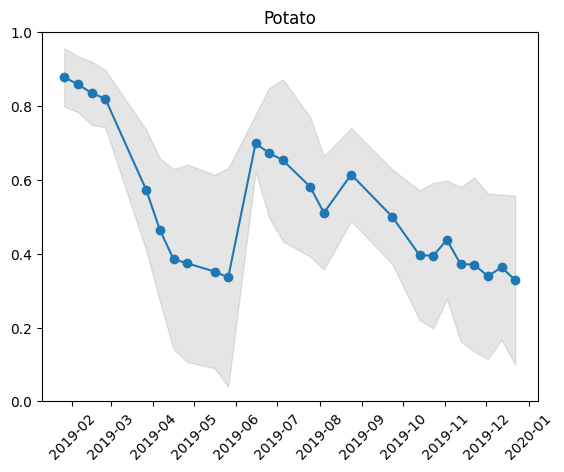

In [13]:
timeser = pd.concat([mean_df, std_df], axis=1).dropna()
timeser.columns = ["Mean NDVI", "SD"]
timeser.index = pd.to_datetime(timeser.index)
timeser = timeser.sort_index()

plt.plot(timeser["Mean NDVI"], "o-")
plt.fill_between(
    timeser.index,
    timeser["Mean NDVI"] - timeser["SD"],
    timeser["Mean NDVI"] + timeser["SD"],
    color="gray",
    alpha=0.2,
)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.title("Potato")
plt.show()

In [14]:
cluster.close()